# El-Niño tengerfelszín hőmérséklet adatok (SST) wavelet elemzése

Az adatok elemzése szorosan követi [C. Torrence és G.P. Compo](http://paos.colorado.edu/research/wavelets/) weboldalán található kiváló leírást és a szerzők "A Practical Guide to Wavelet Analysis" c. [cikkét](http://paos.colorado.edu/research/wavelets/bams_79_01_0061.pdf). Az elemzéshez felhasználjuk Evgeniya Predybaylo által írt [Python függvényeket](http://paos.colorado.edu/research/wavelets/wave_python/waveletFunctions.py) (`waveletFunctions.py`).

Az évszakonként átlagolt, éves ciklus nélküli [adatokat](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) elemezzük. Ehhez először is betöltjük az adatokat a fenti URL-ről és felrajzoljuk (a tmpnb.org-on futtatott munkafüzet esetében használjuk a munkakörnyezetbe feltöltött [sst_nino3.dat](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) állományt):

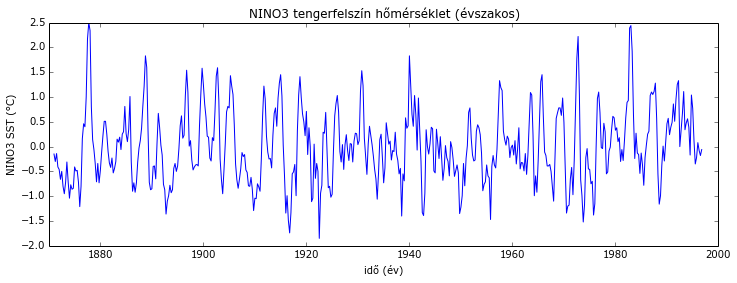

In [1]:
from __future__ import unicode_literals
import numpy as np
from waveletFunctions import wavelet, wave_signif
import matplotlib.pyplot as plt
from urllib2 import urlopen

#url = 'http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat'
#sst = np.loadtxt(urlopen(url))
# tmpnb.org-on az urlopen nem működik, helyette:
sst = np.loadtxt('sst_nino3.dat')
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # időpontok tömbje
xlim = ([1870, 2000])


%matplotlib inline
plt.figure(figsize=(12, 4))
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.xlabel('idő (év)')
plt.ylabel('NINO3 SST (°C)')
plt.title('NINO3 tengerfelszín hőmérséklet (évszakos)')
plt.hold(False)


Ezután kiszámítjuk az adatsor wavelet transzformáltját (CWT). A diszkrét $x_n$ adatsor CWT-jét az $x_n$ és a $\psi_0(\eta)$ anya wavelet átskálázott és eltolt másolataival vett konvolúciójaként számíthatjuk ki:

$$ W_n(s) = \sum_{n'=0}^{N-1} x_{n'} \psi*\left[ \frac{(n'-n)\delta t}{s}\right].$$

Az SST idősor mintavételi időköze $\delta t = ¼$ év. 

## Skála megválasztása

Ha kiválasztottuk az anya wavelet függvényt, akkor ki kell választanunk azokat az $s$ skála értékeket, melyekre kiszámítjuk a CWT-t. Kényelmes a skálát 2 tört kitevőjű hatványaiként megadni:

$$s_j = s_0 2^{j\delta j}, \quad j=0,1,...,J$$

ahol $s_0$ a legkisebb még kiszámítható skála és $J$ határozza meg a legnagyobb skálát. Az $s_0$ értékét úgy kell megválasztani, hogy a $\lambda$ egyenértékű Fourier periódus közelítőleg $2\delta t$ legyen.

A Morlet wavelet esetében az $s$ skálához tartozó egyenértékű Fourier periódus $4\pi s/(\omega_0 +\sqrt{2+\omega_0})$, ami $\omega_0=6$-ra $\lambda = 1.03s$-t ad, tehát jó közelítéssel $s_0 = ½$ év. Az oktávot nyolc rész oktávra bontjuk: $\delta j = 0.125$. $J = 56$, tehát összesen 57 skálát elemzünk (7 oktávot):

In [2]:
pad = 1  # zérus kitöltés (javasolt)
dj = 0.125  # 8 rész-oktáv (egy oktávon belül)
s0 = 2 * dt  # 6 hónapos kezdő skála
j1 = 7 / dj  # 7 oktáv
mother = 'MORLET'

## Folytonos wavelet transzformáció

A transzformációhoz a `waveletFunctions.py` modulban található `wavelet()` függvényt használjuk:

In [3]:
# Wavelet transzformáció:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # energiaspektrum (nem egészen korrekt)
scale_ext = np.outer(scale,np.ones(n))
power = (np.abs(wave))**2 /scale_ext  # energiaspektrum (korrigált)

Felrajzoljuk a wavelet energiaspektrumot:

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


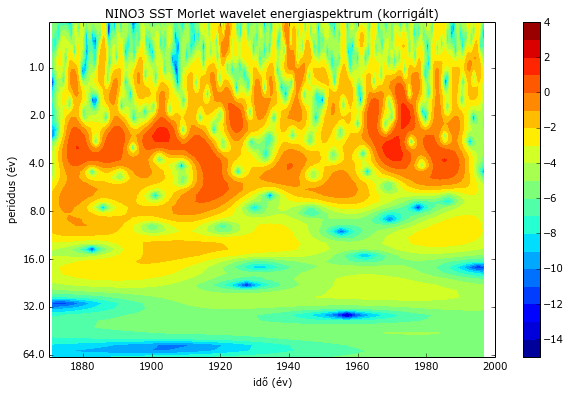

In [4]:
#--- wavelet energiaspektrum (szintvonalas és színes ábra)
import matplotlib
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(time, period, np.log2(power), len(levels))  #*** vagy 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
# im = plt.imshow(np.log2(np.flipud(power)),extent=[1870, 2000, 0.5, 64])
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('NINO3 SST Morlet wavelet energiaspektrum (korrigált)')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.colorbar(im, orientation='vertical')
plt.show()

## Mennyire függ az eredmény a wavelet megválasztásától?

A kérdés megválaszolásához végezzük el az elemzést a DOG wavelettel is.

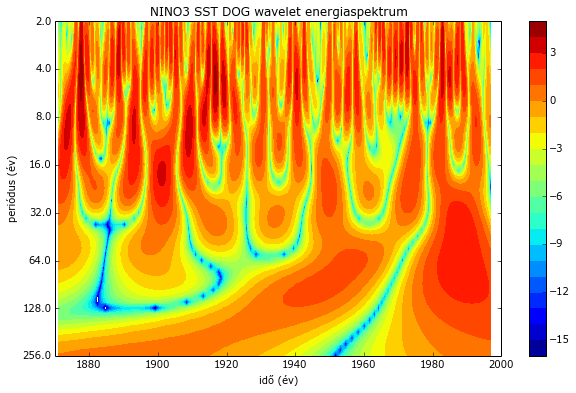

In [5]:
mother = 'DOG'
wave1, period1, scale1, coi1 = wavelet(sst, dt, pad, dj, s0, j1, mother)
power1 = (np.abs(wave1)) ** 2

# felrajzoljuk
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-16,6)])
CS = plt.contourf(time, period1, np.log2(power1), len(levels))  #*** vagy 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
#im = plt.imshow(np.log2(np.flipud(power)),extent=[1870, 2000, 2, 256])
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('NINO3 SST DOG wavelet energiaspektrum')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period1), np.max(period1)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.colorbar(im, orientation='vertical')
plt.show()

## Szignifikánsak-e a talált spektrális csúcsok?

A nullhipotézis konstrukciójához először megfelelő háttér spektrumot kell választani:
* **fehér zaj**  (minden frekvencián azonos energia)
* **vörös zaj** (a frekvencia csökkenésével növekvő energia

Ezután feltételezzük, hogy a sztochasztikus folyamat különböző realizációi e körül a **várható** (átlagos) **háttér spektrum** körül fognak ingadozni
Ezek a várható spektrumok adnak lehetőséget a talált csúcsok szignifikancia vizsgálatára (adott konfidencia szinten)

A szignifikancia szinteket a `wave_signif()` függvénnyel tudjuk kiszámítani. A függvénynek meg kell adni az egyváltozós AR(1) Markov-folyamat egylépéses késleltetéshez tartozó $\alpha$ autokorrelációját ($\alpha=0.72$). Ezt a Niño SST 1- és 2-lépéses késleltetéséhez tartozó $\alpha_1$ és $\alpha_2$ autokorrelációiból becsültük az $\alpha=(\alpha_1 + \sqrt{\alpha_2})/2$ képlet segítségével. Az AR(1) Markov-folyamat

$$x_n=\alpha x_{n-1} + z_n,$$

ahol $x_0=0$ és $z_n$ normális eloszlású fehér zaj. A fenti Markov-folyamat diszkrét normalizált energia- (teljesítménysűrűség-) spektruma

$$P_k=\frac{1-\alpha^2}{1+\alpha^2-2\alpha\cos (2\pi k/N)},$$

ahol $k=0,... N/2$ a frekvencia index.



/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


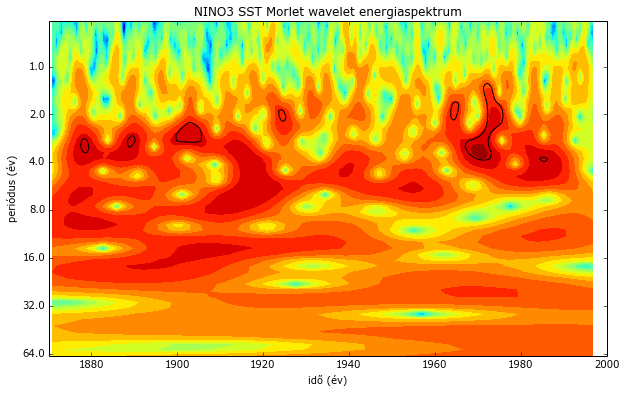

In [6]:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, 'MORLET')
power = (np.abs(wave)) ** 2
# szignifikancia szintek
signif = wave_signif(([1.0]), dt=dt, sigtest=0, scale=scale, lag1=0.72, mother='MORLET')
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # ahol > 1-nél, ott az energia szignifikáns

# ábra
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(time, period, np.log2(power), len(levels))  #*** vagy 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('NINO3 SST Morlet wavelet energiaspektrum')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
# 95%-os szignifikancia szint
plt.hold(True)
plt.contour(time, period, sig95, [-99, 1], colors='k')
plt.show()

## A normalizáció korrekt-e?

A $\psi_0$ anya wavelet Fourier transzformáltja, $\hat{\psi}_0$ egységnyi energiára normalizált

$$ \int_{-\infty}^{\infty}\left| \hat{\psi}_0(\omega')\right|^2 d\omega' = 1.$$

A Parseval-egyenlőség miatt az anya wavelet is energiára normalizált

$$ \int_{-\infty}^{\infty}\left| \hat{\psi}_0(\omega')\right|^2 d\omega' = \int_{-\infty}^{\infty}\left| \psi_0(\eta)\right|^2 d\eta.$$

Annak érdekében, hogy a CWT transzformáltak mindegyik $s$ skálán közvetlenül összehasonlíthatók legyenek, egységnyi energiára kell normalizálni az átskálázott anya waveleteket:

$$ \hat{\psi}(s \omega_k) = \left( \frac{2\pi s}{\delta t} \right)^{1/2} \hat{\psi}_0(s \omega_k)$$.

Nézzük meg, mi lesz **három, egységnyi amplitúdójú, de eltérő frekvenciájú** ($T$ periódusú) **szinusz hullám wavelet energiaspektruma**

$$x_n = \sin\left(2\pi\frac{n\delta t}{T_1} \right) + \sin\left(2\pi\frac{n\delta t}{T_2} \right) + \sin\left(2\pi\frac{n\delta t}{T_3} \right) $$


In [7]:
N = 512
dt = 0.25
t = np.arange(N) * dt
T1 = 1.0
T2 = 4.0
T3 = 16.0
w1 = 2 * np.pi / T1
w2 = 2 * np.pi / T2
w3 = 2 * np.pi / T3
s3 = np.sin(w1 * t) + np.sin(w2 * t) + np.sin(w3 * t)

pad = 1      # zérus kitöltés (javasolt)
dj = 0.125   # 8 részoktáv
s0 = 2*dt    # 6 hónapos kezdő skála
j1 = 7/dj    # 7 oktáv
mother = 'MORLET'  # anya wavelet
wave, period, scale, coi = wavelet(s3, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2

Rajzoljuk fel a jelet és a wavelet energiaspektrumot:

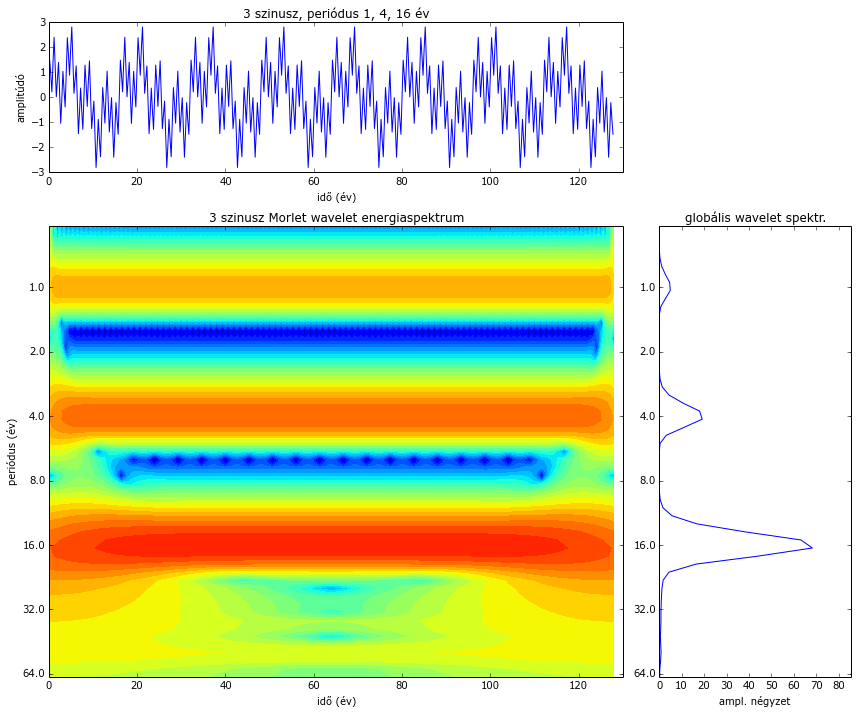

In [8]:
variance = np.std(s3, ddof=1) ** 2
global_ws = variance * (np.sum(power, axis=1) / n)  # idő-átlagolt globális spektrum

from matplotlib import gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])

#--- jel
xlim = ([0, 130])
plt.figure(figsize=(12, 10))
plt.subplot(gs[0,0])
plt.plot(t, s3)
plt.xlim(xlim[:])
plt.xlabel('idő (év)')
plt.ylabel('amplitúdó')
plt.title('3 szinusz, periódus 1, 4, 16 év')
plt.hold(False)

#--- wavelet energiaspektrum
plt3 = plt.subplot(gs[1,0])
levels = np.array([2**i for i in range(-18,10)])
CS = plt.contourf(t, period, np.log2(power), len(levels))  #*** or use 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('3 szinusz Morlet wavelet energiaspektrum')
plt.xlim(xlim[:])
plt.hold(False)
# format y-scale
plt3.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()

#--- globális wavelet spektrum
plt4 = plt.subplot(gs[1,1])
plt.plot(global_ws, period)
plt.hold(False)
plt.xlabel('ampl. négyzet')
#plt.ylabel('periódus (év)')
plt.title('globális wavelet spektr.')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()

plt.tight_layout()

plt.show()

Jól látható, hogy a három azonos amplitúdójú szinusz függvény CWT-je közel sem lesz azonos energiájú. Ezzel a kérdéssel foglalkozik Liu et al.(2007): Rectification of the Bias in the Wavelet Power Spectrum *Journal of Atmospheric and Oceanic Technology*, 24(12), 2093-2102, amely letölthető a szerző [honlapjáról](http://ocgweb.marine.usf.edu/~liu/wavelet.html).

Liu et al. javasolták, hogy a szokásos $|W_n(s)|^2$ normalizáció helyett az $1/s_j\;|W_n(s)|^2$ normalizációt használjuk (skála inverzével van szorozva a CWT energiája).

Nézzük meg, hogy mit eredményez ez az alternatív normalizáció a fenti példában.

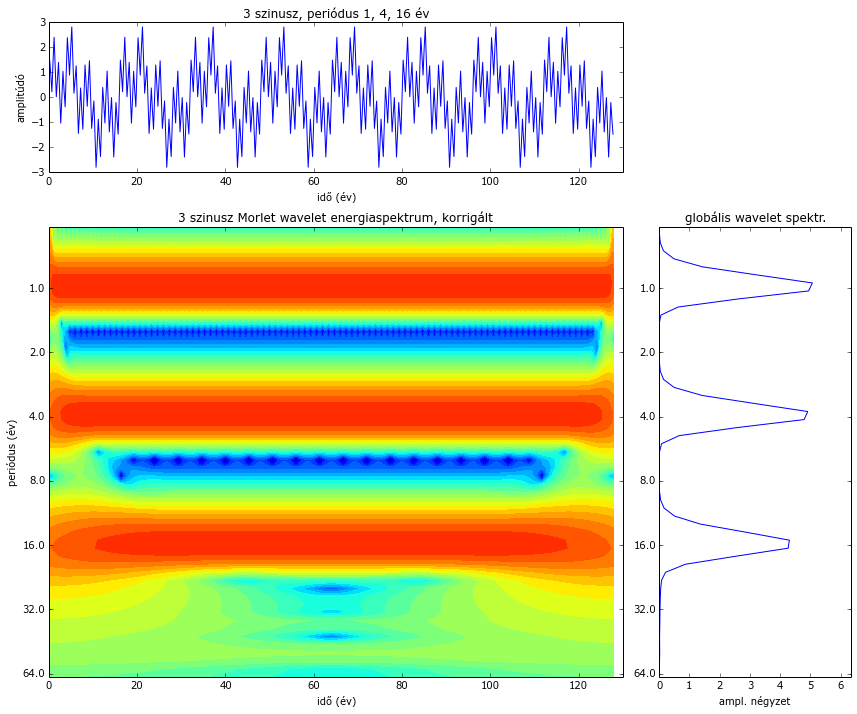

In [9]:
scale_ext = np.outer(scale,np.ones(N))
power = (np.abs(wave))**2 /scale_ext  # energiaspektrum (korrigált)
global_ws = variance * (np.sum(power, axis=1) / n)  # idő-átlagolt globális spektrum

gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])

#--- jel
xlim = ([0, 130])
plt.figure(figsize=(12, 10))
plt.subplot(gs[0,0])
plt.plot(t, s3)
plt.xlim(xlim[:])
plt.xlabel('idő (év)')
plt.ylabel('amplitúdó')
plt.title('3 szinusz, periódus 1, 4, 16 év')
plt.hold(False)

#--- wavelet energiaspektrum
plt3 = plt.subplot(gs[1,0])
levels = np.array([2**i for i in range(-20,6)])
CS = plt.contourf(t, period, np.log2(power), len(levels))  #*** or use 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('3 szinusz Morlet wavelet energiaspektrum, korrigált')
plt.xlim(xlim[:])
plt.hold(False)
# format y-scale
plt3.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()

#--- globális wavelet spektrum
plt4 = plt.subplot(gs[1,1])
plt.plot(global_ws, period)
plt.hold(False)
plt.xlabel('ampl. négyzet')
#plt.ylabel('periódus (év)')
plt.title('globális wavelet spektr.')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()

plt.tight_layout()

plt.show()


Most az egyes szinusz hullámok már közel azonos energiájúak. Viszont van egy bökkenő. A fehérzaj *korrigált* spektruma nem azonos teljesítményű az összes frekvencián, tehát a szignifikancia vizsgálathoz a **nem korrigált érték** kell.

(Feladat: A fenti állítást támassza alá normális eloszlású fehér zaj kétféle normalizáció szerinti folytonos wavelet transzformáltjainak kiszámításával! A számítások eredményeit az alábbi ábra formájában közöljük:)

![Fehérzaj kétféle normalizációval](wn.png "Normális eloszlású fehérzaj CWT-je kétféle normalizációval")


## Hatáskúp

Mivel az adatsor hossza véges, a wavelet spektrum eleje és vége hibás lesz, mivel a Fourier transzformált **periódikus** adatsort tételez fel. Lehetséges megoldás az idősort zérusokkal feltölteni a transzformáció előtt, utána pedig ezeket eltávolítani. A zérussal való feltöltés ugrást eredményez a végpontokban, és az egyre nagyobb skálák esetén a szélek közelében egyre jobban csökkenti az amplitúdót. A **hatáskúp** (COI) a wavelet spektrumnak az a része, ahol a peremhatás fontossá válik. Úgy határozzuk meg, hogy az az idő, melyre az adott skálán a wavelet autokorreláció $e$-ed részére, a wavelet energia $e^2$-ed részére csökken. Periódusos adatok esetében nincs szükség zérus feltöltésre, ezért nincs hatáskúp.

Számítsuk ki és rajzoljuk fel a Niño SST adatok CWT-je (korrigált spektrum) esetében a hatáskúpot.

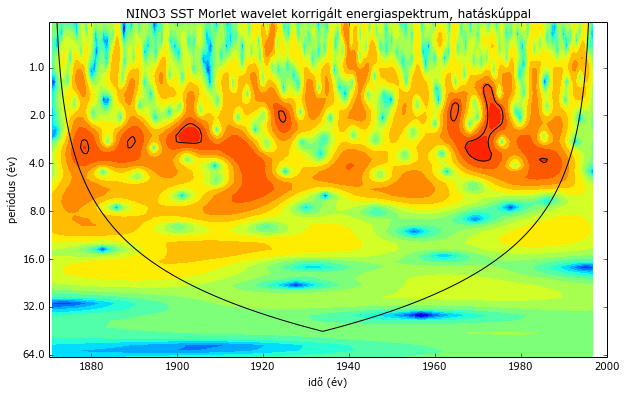

In [10]:
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # időpontok tömbje
xlim = ([1870, 2000])

wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, 'MORLET')
power = (np.abs(wave)) ** 2
# szignifikancia szintek - ezeket a nem korrigált spektrummal kell számítani!
signif = wave_signif(([1.0]), dt=dt, sigtest=0, scale=scale, lag1=0.72, mother='MORLET')
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # ahol > 1-nél, ott az energia szignifikáns

scale_ext = np.outer(scale,np.ones(n))
power = (np.abs(wave))**2 /scale_ext  # energiaspektrum (korrigált)

# ábra
plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(time, period, np.log2(power), len(levels))  #*** vagy 'contour'
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('NINO3 SST Morlet wavelet korrigált energiaspektrum, hatáskúppal')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
# 95%-os szignifikancia szint
plt.hold(True)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# hatáskúp (COI)
plt.plot(time, coi, 'k')
plt.hold(False)
plt.show()

## Fázis

A komplex Morlet wavelet spektrum fázisát is felrajzolhatjuk. A kapott ábra a wavelet transzformált azonos fázisú helyeit mutatja meg (hullám taréjok és teknők).

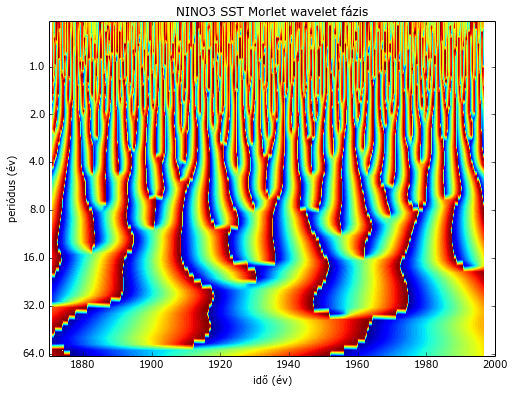

In [11]:
phase = (np.angle(wave))

plt.figure(figsize=(8, 6))
levels = np.arange(-np.pi,np.pi,0.1)
CS = plt.contourf(time, period, phase, len(levels))  #*** vagy 'contour'
im = plt.contourf(CS, levels=levels)
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('NINO3 SST Morlet wavelet fázis')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

## Inverz wavelet transzformáció (rekonstrukció)

Nem ortogonális wavelet transzformáció bázis esetén, amilyen a CWT, az inverzió redundáns: az idősor visszaállítása *sokféle* wavelet függvény segítségével lehetséges. A legegyszerűbb az inverz CWT (iCWT) a delta ($\delta$) függvénnyel. A rekonstruált idősor a különböző skálákon vett wavelet transzformáció valós részeinek az összege minden skálára:

$$ x_n=\frac{\delta j \delta t^{1/2}}{C_\delta \psi_0(0)} \sum_{j=0}^J \frac{\Re \left\{ W_n(s_j) \right\} }{s_j^{1/2}}$$

A $\psi_0(0)$ faktor az energia skálázást küszöböli ki és $s_j^{1/2}$ a wavelet transzformáltat energia sűrűségre konvertálja, míg a $C_\delta$ szorzó waveletenként más és más.

Számítsuk ki az **SST adatsor inverz wavelet transzformáltját**. Ehhez először definiáljuk a rekonstrukcióhoz szükséges Python eljárást (ezt nem tartalmazza a Evgeniya Predybaylo által írt Python kód):

In [12]:
def icwt(W, sj, dt, dj=1/8, mother='morlet'):
    """
    Folytonos inverz wavelet transzformáció.

    Paraméterek
    ----------
    W : a wavelet transzformált
    sj : skála indexek vektora
    dt : mintavételezés intervalluma
    dj : diszkrét skála intervallum, alapértelmezésben 0.125.
    mother : anya wavelet (alapértelmezés: Morlet)
    
    Eredmény
    --------
    iW : inverz wavelet transzformált
    """
    mother = mother.upper()
    if mother == 'MORLET':
        Cd = 0.7785  
        psi0 = 0.751126
    elif mother == 'PAUL': # Paul, m=4
        Cd = 1.132
        psi0 = 1.07894
    elif mother == 'DOG':   # Dog, m=2
        Cd = 3.541
        psi0 = 0.86733
    else:
        raise Error('Mother must be one of Morlet, Paul, DOG')

    a, b = W.shape
    c = sj.size
    if a == c:
        sj = (np.ones([b, 1]) * sj).transpose()
    elif b == c:
        sj = np.ones([a, 1]) * sj
    else:
        raise Warning('Input array dimensions do not match.')

    # Torrence és Compo (1998), eq. (11)
    iW = dj * np.sqrt(dt) / (Cd * psi0) * (
        np.real(W) / np.sqrt(sj)).sum(axis=0)
    return iW

Számítsuk ki a rekonstruált idősort. Rajzoljuk fel az eredeti adatsort, a rekonstruált adatsort és az eltéréseket:

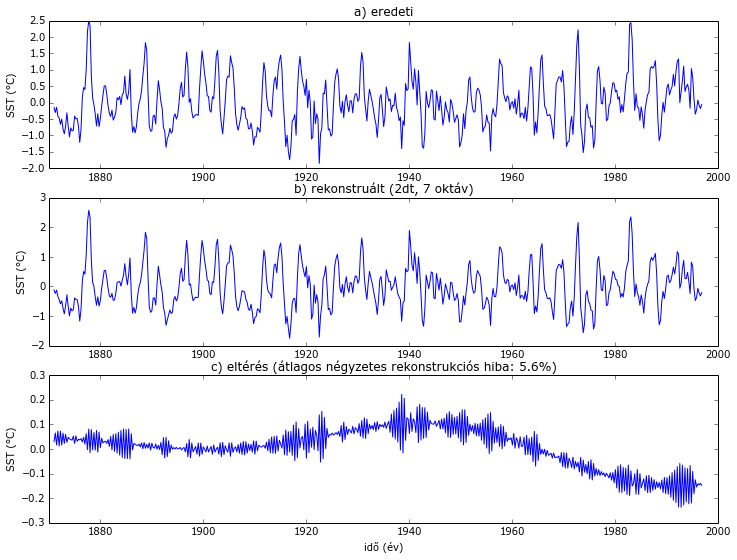

In [13]:
s0 = 2 * dt   # 6 hónapos kezdő skála
j1 = 7 / dj   # 7 oktáv

wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)

# inverz wavelet transzformáció
x = icwt(wave, scale, dt, dj, 'morlet')

# eredeti adatsor
plt.figure(figsize=(12, 9))
plt.subplot(311)
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.ylabel('SST (°C)')
plt.title('a) eredeti')
plt.hold(False)

# rekonstruált adatsor
plt.subplot(312)
plt.plot(time, x)
plt.xlim(xlim[:])
#plt.xlabel('idő (év)')
plt.ylabel('SST (°C)')
plt.title('b) rekonstruált (2dt, 7 oktáv)')
plt.hold(False)

# hiba
plt.subplot(313)
plt.plot(time, x-sst)
plt.xlim(xlim[:])
plt.xlabel('idő (év)')
plt.ylabel('SST (°C)')
plt.title('c) eltérés (átlagos négyzetes rekonstrukciós hiba: 5.6%)')
plt.hold(False)

A rekonstrukció hibájának számszerű jellemzésére az eltérések szórásának a jel nagyságához (variancia) viszonyított százalékos eltérését adhatjuk meg:

In [14]:
# átlagos négyzetes rekonstrukciós hiba százalékban
print "átlagos négyzetes rekonstrukciós hiba = %.3f %%" % (100*np.std(x-sst)/variance)

átlagos négyzetes rekonstrukciós hiba = 5.578 %


A CWT paramétereit változtatva csökkenthető a rekonstrukció hibája, ha a kezdő skála $s_0$ értéket csökkentjük, illetve több oktávra végezzük el az elemzést.

átlagos négyzetes rekonstrukciós hiba = 0.023 %


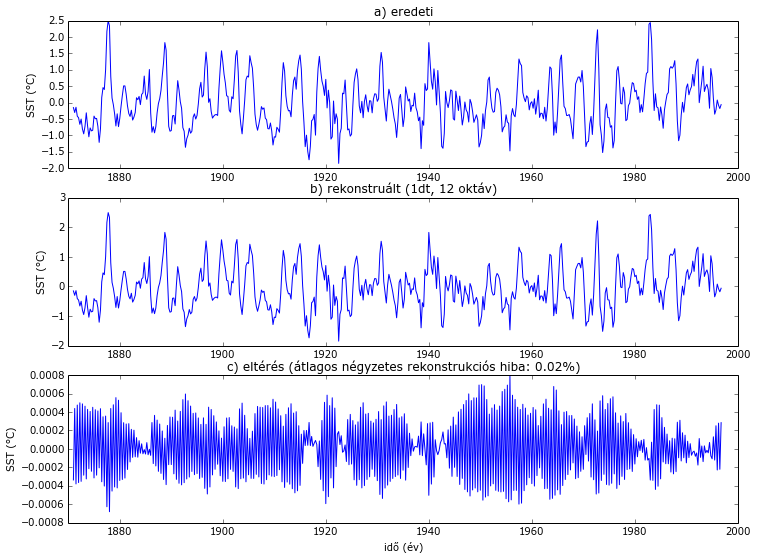

In [15]:
s0 = 2*dt/2.0  # 3 hónapos kezdő skála
j1 = 12 / dj  # 12 oktáv
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)

# inverz wavelet transzformáció
x = icwt(wave, scale, dt, dj, 'morlet')

# eredeti adatsor
plt.figure(figsize=(12, 9))
plt.subplot(311)
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.ylabel('SST (°C)')
plt.title('a) eredeti')
plt.hold(False)

# rekonstruált adatsor
plt.subplot(312)
plt.plot(time, x)
plt.xlim(xlim[:])
#plt.xlabel('idő (év)')
plt.ylabel('SST (°C)')
plt.title('b) rekonstruált (1dt, 12 oktáv)')
plt.hold(False)

# hiba
plt.subplot(313)
plt.plot(time, x-sst)
plt.xlim(xlim[:])
plt.xlabel('idő (év)')
plt.ylabel('SST (°C)')
plt.title('c) eltérés (átlagos négyzetes rekonstrukciós hiba: 0.02%)')
plt.hold(False)

# átlagos négyzetes rekonstrukciós hiba százalékban
print "átlagos négyzetes rekonstrukciós hiba = %.3f %%" % (100*np.std(x-sst)/variance)

## További lehetséges témák

* Szűrés waveletekkel
* Globális wavelet spektrum (idő és skála átlagolás, simítás)
* Wavelet kereszt-spektrum, koherencia
* Többváltozós (komplex) folytonos WT
* Diszkrét diadikus WT, skálázó függvények
* Sokskálás analízis (MRA)
* Operátor tömörítés waveletekkel
* Saját adatok elemzése waveletekkel 